In [135]:
import os
import tensorflow as tf
import glob
import pathlib
from tensorflow import keras
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.layers import Dense,Conv2D,Flatten

In [136]:
train="../input/vegetable-image-dataset/Vegetable Images/test"
test="../input/vegetable-image-dataset/Vegetable Images/train"
valid="../input/vegetable-image-dataset/Vegetable Images/validation"

In [137]:
def process(data):
    path=pathlib.Path(data)#converting the dtring to path
    filepaths=list(path.glob(r"*/*.jpg"))#Going through all the subpaths 
    labels=list(map(lambda x: os.path.split(os.path.split(x)[0])[1],filepaths))#Separating the label from filepath and storing it
    df1=pd.Series(filepaths,name='filepaths').astype(str)
    df2=pd.Series(labels,name='labels')
    df=pd.concat([df1,df2],axis=1)#Making the dataframe
    return df

In [138]:
df_train=process(train)
df_test=process(test)
df_valid=process(valid)

In [139]:
df_test.head()


,filepaths,labels
0,../input/vegetable-image-dataset/Vegetable Ima...,Broccoli
1,../input/vegetable-image-dataset/Vegetable Ima...,Broccoli
2,../input/vegetable-image-dataset/Vegetable Ima...,Broccoli
3,../input/vegetable-image-dataset/Vegetable Ima...,Broccoli
4,../input/vegetable-image-dataset/Vegetable Ima...,Broccoli


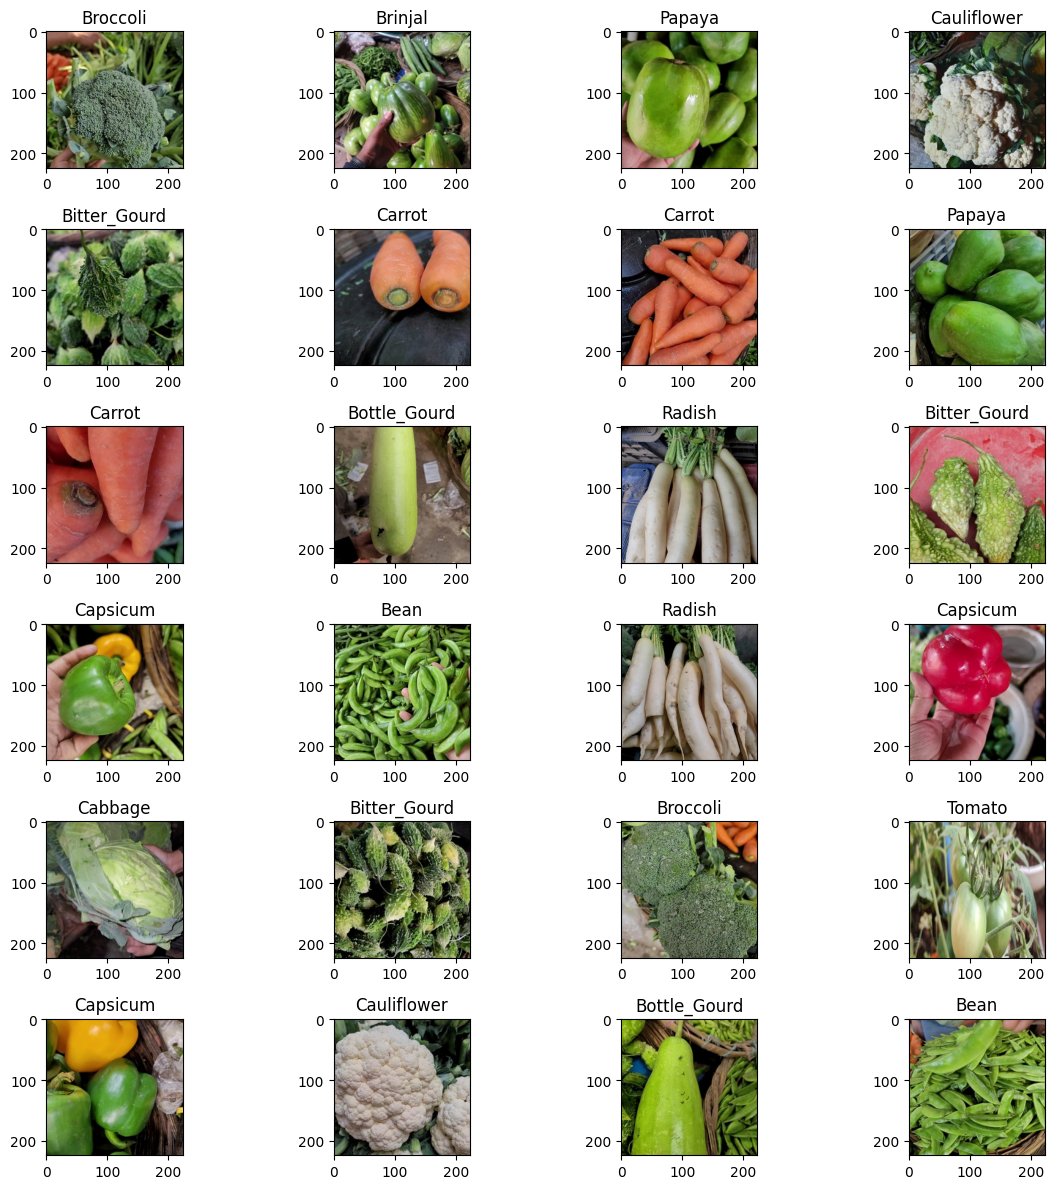

In [140]:
df_train=df_train.sample(frac=1).reset_index(drop=True)#Shuffling the dataframe so we can get random vegetable pictures
fig,axes=plt.subplots(nrows=6,ncols=4,figsize=(12,12))

for i,ax in enumerate(axes.flat):
    x=plt.imread(df_train['filepaths'][i])#reading the image
    ax.imshow(x)
    ax.set_title(df_train['labels'][i])
plt.tight_layout()    
plt.show()

In [141]:
train_generator=ImageDataGenerator( preprocessing_function=preprocess_input)
test_generator=ImageDataGenerator( preprocessing_function=preprocess_input)
valid_generator=ImageDataGenerator( preprocessing_function=preprocess_input)

In [142]:
train_image=train_generator.flow_from_dataframe(dataframe=df_train,
                                                x_col='filepaths',
                                                y_col='labels',
                                                target_size=(224,224),
                                                batch_size=16, #Altered for Hyperparameter Tuning
                                                subset='training',
                                                random_seed=42)

test_image = test_generator.flow_from_dataframe(
    dataframe=df_test,
    x_col='filepaths',
    y_col='labels',
    target_size=(224,224),
    batch_size=32
)

valid_image = test_generator.flow_from_dataframe(
    dataframe=df_valid,
    x_col='filepaths',
    y_col='labels',
    subset='training',
    target_size=(224,224),
    batch_size=32
)

Found 3000 validated image filenames belonging to 15 classes.
Found 15000 validated image filenames belonging to 15 classes.
Found 3000 validated image filenames belonging to 15 classes.


In [143]:
pretrained_model = ResNet50(
    input_shape=(224,224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)
pretrained_model.trainable = False

94765736/94765736 [==============================] - 0s 0us/step


In [144]:
inputs = pretrained_model.input

x = Dense(120, activation='relu')(pretrained_model.output)
x = Dense(120, activation='relu')(x)#adding some custom layers of our choice

outputs = Dense(15, activation='softmax')(x)
#output choice
model = Model(inputs=inputs, outputs=outputs)

In [145]:
model.compile(
    optimizer='adam', # Altered for Hyperparameter Tuning
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [146]:
mo_fit=model.fit(train_image,validation_data=valid_image,epochs=5)

Epoch 1/5
188/188 [==============================] - 632s 3s/step - loss: 0.2659 - accuracy: 0.9310 - val_loss: 0.0307 - val_accuracy: 0.9933
Epoch 2/5
188/188 [==============================] - 627s 3s/step - loss: 0.0134 - accuracy: 0.9963 - val_loss: 0.0150 - val_accuracy: 0.9953
Epoch 3/5
188/188 [==============================] - 627s 3s/step - loss: 0.0056 - accuracy: 0.9990 - val_loss: 0.0200 - val_accuracy: 0.9940
Epoch 4/5
188/188 [==============================] - 617s 3s/step - loss: 0.0093 - accuracy: 0.9977 - val_loss: 0.0089 - val_accuracy: 0.9970
Epoch 5/5
188/188 [==============================] - 627s 3s/step - loss: 4.8388e-04 - accuracy: 1.0000 - val_loss: 0.0082 - val_accuracy: 0.9967


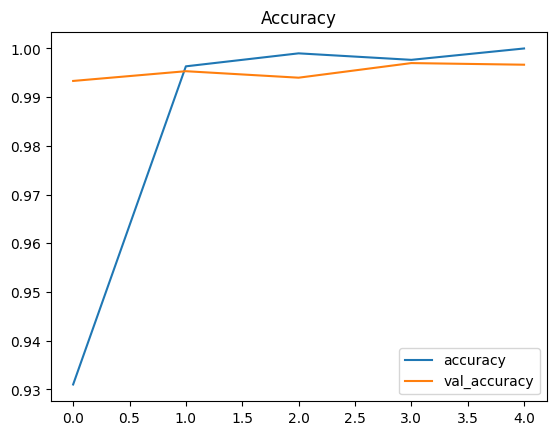

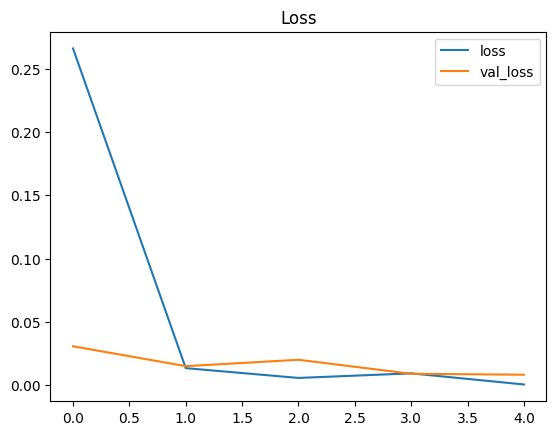

In [147]:
pd.DataFrame(mo_fit.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()
pd.DataFrame(mo_fit.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()